# Implementation of Kao et al.

Most of this code is based on "Understanding Hyperbole using RSA" [as retrieved here](https://pyro.ai/examples/RSA-hyperbole.html) and then adjusted for the particular example discussed in the paper.

Kao, J. T., Wu, J. Y., Bergen, L., & Goodman, N. D. (2014). Nonliteral understanding of number words. Proceedings of the National Academy of Sciences, 111(33), 12002-12007.

In [1]:
import torch
torch.set_default_dtype(torch.float64)
import math
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

import sys; sys.path.append('/home/rnouwen/abu/ipyth/probmods-pyro/')
from search_inference import HashingMarginal, memoize, Search

import collections
import argparse

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np


/home/rnouwen/rickpyvenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


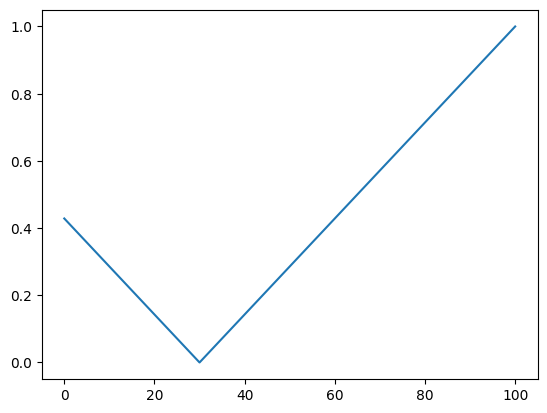

In [6]:
def Marginal(fn):
    return memoize(lambda *args: HashingMarginal(Search(fn).run(*args)))

State = collections.namedtuple("State", ["price", "arousal"])

#states = list(range(0,102,2)) # this will take pretty long to crunch; range(0,105,5) speeds things up
states = list(range(0,105,5))

mean = 30
sd = 10 

def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

prior_unnormal = list(map(lambda s: normpdf(s,mean,sd),states))
prior_normal = torch.tensor([i/sum(prior_unnormal) for i in prior_unnormal])

def price_prior():
    values = states
    probs = prior_normal
    ix = pyro.sample("price", dist.Categorical(probs=probs))
    return values[ix]

def arousal_p(price):
    x=abs(30-price)   # P of arousal increases as normality decreases
    return x.real

arousal_prior_list = list(map(arousal_p,states))

arousal_prior_list = torch.tensor([i/max(arousal_prior_list) for i in arousal_prior_list])

plt.plot(states,arousal_prior_list)

prior_p_affect = sum(arousal_prior_list*prior_normal)

In [7]:
def arousal_prior(price):
    price_position = states.index(price)
    return pyro.sample("arousal", dist.Bernoulli(probs=arousal_prior_list[price_position])).item() == 1

def state_prior():
    price = price_prior()
    state = State(price=price, arousal=arousal_prior(price))
    return state

@Marginal
def project(dist,qud):
    v = pyro.sample("proj",dist)
    return qud_fns[qud](v)

@Marginal
def literal_listener(utterance):
    state=state_prior()
    pyro.factor("literal_meaning", 0. if meaning(utterance, state.price) else -999999.)
    return state

@Marginal
def speaker(state, qud):
    alpha = 1.
    qudValue = qud_fns[qud](state)
    with poutine.scale(scale=torch.tensor(alpha)):
        utterance = utterance_prior()
        literal_marginal = literal_listener(utterance)
        projected_literal = project(literal_marginal, qud)
        pyro.sample("listener", projected_literal, obs=qudValue)
    return utterance

#The QUD functions we consider:
qud_fns = {
    "price": lambda state: State(price=state.price, arousal=None),
    "arousal": lambda state: State(price=None, arousal=state.arousal),
    "priceArousal": lambda state: State(price=state.price, arousal=state.arousal),
}

def qud_prior():
    values = list(qud_fns.keys())
    ix = pyro.sample("qud", dist.Categorical(probs=torch.ones(len(values)) / len(values)))
    return values[ix]

def utterance_prior():
    utterances = states
    ix = pyro.sample("utterance", dist.Categorical(probs=torch.ones(len(utterances)) / len(utterances)))
    return utterances[ix]

def meaning(utterance, price):
    return utterance == price

@Marginal
def pragmatic_listener(utterance):
    state = state_prior()
    qud = qud_prior()
    speaker_marginal = speaker(state, qud)
    pyro.sample("speaker", speaker_marginal, obs=utterance)
    return state

def extractdist(d):
    support = d.enumerate_support()
    data = [d.log_prob(s).exp().item() for s in d.enumerate_support()]
    names = list(map(str, support))
    df = pd.DataFrame({'state':names, 'P':data})
    return df

In [8]:
interpret = extractdist(pragmatic_listener(100))

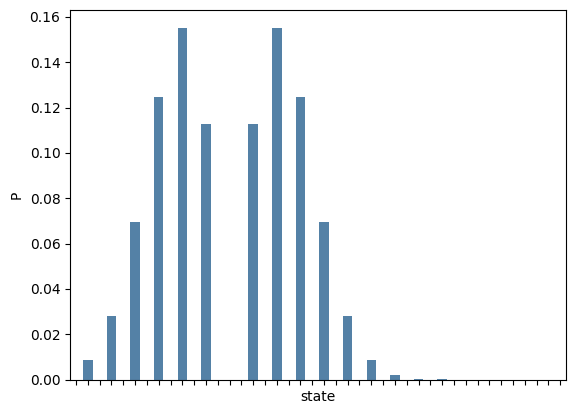

In [9]:
plotje=sns.barplot(data=interpret,x='state',y='P',color='steelblue')
plt.xticks(visible=False)#rotation=90)
plt.show()

## Exporting the results to csv (for plots in R) 

I prefer ggplot.

In [38]:
df = interpret

df["attendees"] = list(map(lambda x: eval(x)[0], df.state))
df["affect"] = list(map(lambda x: eval(x)[1], df.state))
df["distribution"] = 'posterior'

df2 = pd.DataFrame({'state':['NA']*len(states),'P':prior_normal,'attendees':states,'affect':['NA']*len(states),'distribution':['pior']*len(states)})
df3 = pd.concat([df,df2])
df3.to_csv('~/abu/draft/sub23proceedings/kaosimplesim.csv')

In [7]:
interpret = extractdist(pragmatic_listener(40))
df = interpret

df["attendees"] = list(map(lambda x: eval(x)[0], df.state))
df["affect"] = list(map(lambda x: eval(x)[1], df.state))
df["distribution"] = 'posterior'

df2 = pd.DataFrame({'state':['NA']*len(states),'P':prior_normal,'attendees':states,'affect':['NA']*len(states),'distribution':['pior']*len(states)})
df3 = pd.concat([df,df2])
df3.to_csv('~/abu/draft/sub23proceedings/kaosimplesim40.csv')